# Mini Lab : Logistic Regression and Support Vector Machine

### Group 3 - Members:

_Tai Chowdhury_<br>
_Apurv Mittal_<br>
_Ravi Sivaraman_<br>
_Seemant Srivastava_<br>


## Introduction

As discussed in Lab 1, we have acquired the Australian Weather dataset from Kaggle portal. It contains 10 years of weather data collected from many locations across Australia. These are daily weather observations. There are 145,459 observations with 23 attributes in the original dataset. 

We have chosen RainTomorrow (categorical) and Rainfall (continuous) as predictor variables. RainTomorrow is a categorical attribute which indicates whether it is going to rain tomorrow - yes or no. Rainfall is a continuous attribute that measures amount of rainfall each of the particular locations have received (in mm). Using our models, we will be able to design an algorithm where the bureau can help to predict rainfall for different regions in Australia.

In this Lab 2 assignment, we have measured the accuracy and effectiveness of our model for categorical variable RainTomorrow by using 10-fold cross validation against the confusion matrix measurements like: Precision, Recall and Accuracy. We have explored the methods of logistic regression and support vector machine (SVM) models on our dataset. 

We have used `scikit-learn` packages for our exploration. We ran logistic regression models with all the available solvers in the `scikit-learn` package and compare the effictiveness and accuracy of the model to predict `RainfallTomorrow`. We also measured the duration of model run from each models to compare model performance and efficiency as well.
 
To get started, we will start with loading all the necessary packages for our analysis. We will start our analysis with `df_impute` which is the imputed dataframe from our last explanatory data analysis Lab 1 project. Using this dataframe will ensure data consistency for all the labs going forward.

In [2]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from scipy import stats
import warnings
from shapely.geometry import Point
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

In [3]:
#Ignore Warnings on final

warnings.filterwarnings('ignore')

## Imputed Data
We imputed data in EDA and reusing imputed data from EDA (Lab1) project.
Here is the link to the EDA

https://nbviewer.jupyter.org/github/ravisiv/AussieWeatherEDA/blob/c0ba412cb75da21eba386ea9ea39f645ad6af1d0/DS7331_Lab1_Group3_Ravi_Taifur_Seemant_Apurv_Submission.ipynb


In [4]:
# Read the Imputed Australia weather data
df_impute = pd.read_csv("weatherAUS_imputed.csv")

In [5]:
#  View the top rows of the data imported
df_impute.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,6.032209,8.890686,W,44.0,W,WNW,20.0,...,71.0,22.0,1007.7,1007.1,8.000000,3.684394,16.9,21.8,No,No
1,7.4,25.1,0.0,6.032209,8.890686,WNW,44.0,NNW,WSW,4.0,...,44.0,25.0,1010.6,1007.8,3.635105,3.684394,17.2,24.3,No,No
2,12.9,25.7,0.0,6.032209,8.890686,WSW,46.0,W,WSW,19.0,...,38.0,30.0,1007.6,1008.7,3.635105,2.000000,21.0,23.2,No,No
3,9.2,28.0,0.0,6.032209,8.890686,NE,24.0,SE,E,11.0,...,45.0,16.0,1017.6,1012.8,3.635105,3.684394,18.1,26.5,No,No
4,17.5,32.3,1.0,6.032209,8.890686,W,41.0,ENE,NW,7.0,...,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,No,No


The imputed data doesn't include any null or missing values. Also, we have dropped the columns like: Date of observation and City Name.

In [6]:
df_impute_num = df_impute.columns[df_impute.dtypes == 'float64']
df_impute_cat=df_impute.columns[df_impute.dtypes == 'object']
print("Numeric Variables:", df_impute_num)
print("Categorical Variables:", df_impute_cat)

Numeric Variables: Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm'],
      dtype='object')
Categorical Variables: Index(['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'], dtype='object')


Before continuing further, we need to check which variables are numeric and which are not. As the models expect numerical variables. We will filter and identify non-numeric variables.

`WindGustDir`, `WindDir9am`, `WindDir3pm`, `RainToday` and `RainTomorrow`are not numeric. Here `RainTomorrow` is our response variable. we handle the other variables with hot-one-encoding later in the flow.

In [7]:
#Keep the original data
df_model = df_impute.copy()

Creating a new DataFrame `df_model` for modeling to avoid any changes to the original dataset `df_impute`.

In [8]:
# Create a new variable to Identify if it RainToday

df_model["IsRainToday"] = df_impute['RainToday']

# Replacing No with 0 and Yes with 1.

df_model['IsRainToday'].replace({'No': 0, 'Yes': 1},inplace = True)


Assigning `0` to No values and `1` to Yes values in `RainToday` (Changed to `IsRainToday`)

In [10]:
print("df_impute", df_impute.shape)
print("df_model", df_model.shape)


df_impute (140787, 21)
df_model (140787, 22)


In [11]:
# Printing the values to check if the data looks good

df_model.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,IsRainToday
0,13.4,22.9,0.6,6.032209,8.890686,W,44.0,W,WNW,20.0,...,22.0,1007.7,1007.1,8.000000,3.684394,16.9,21.8,No,No,0
1,7.4,25.1,0.0,6.032209,8.890686,WNW,44.0,NNW,WSW,4.0,...,25.0,1010.6,1007.8,3.635105,3.684394,17.2,24.3,No,No,0
2,12.9,25.7,0.0,6.032209,8.890686,WSW,46.0,W,WSW,19.0,...,30.0,1007.6,1008.7,3.635105,2.000000,21.0,23.2,No,No,0
3,9.2,28.0,0.0,6.032209,8.890686,NE,24.0,SE,E,11.0,...,16.0,1017.6,1012.8,3.635105,3.684394,18.1,26.5,No,No,0
4,17.5,32.3,1.0,6.032209,8.890686,W,41.0,ENE,NW,7.0,...,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,No,No,0


We can observe that the presence of “0” and “1” is almost in the 78:22 ratio. So there is a class imbalance and we have to deal with it. To fight against the class imbalance, we will use here the oversampling of the minority class. Since the size of the dataset is quite small, majority class subsampling wouldn’t make much sense here.

## One-hot encoding

Before we create our models, we need to format our attributes. We are converting `RainToday` and `RainTomorrow` into numeric variables to `0` and `1`. We also decided to go ahead with one-hot-encoding `WindGustDir`, `WindDir9am`, and `WindDir3pm` attributes based on the direction of the wind. 

In [12]:
# perform one-hot encoding using dummies

gust_df = pd.get_dummies(df_model.WindGustDir,prefix='GustDir')
wind3pm_df = pd.get_dummies(df_model.WindDir3pm,prefix='Wind3pm')
wind9am_df = pd.get_dummies(df_model.WindDir9am,prefix='Wind9am')
df_model = pd.concat((df_model,gust_df, wind3pm_df, wind9am_df),axis=1) # add back into the dataframe


We decided to do one-hot-encoding using dummies function as machine learning algorithms and models requires numerical values for both input and output attributes.

In [13]:
# Drop categorical columns

df_model = df_model.drop(['WindDir3pm', 'WindDir9am', 'WindGustDir', 'RainToday'], axis = 1)

After conversions, we are removing these categorical attributes to avoid duplicates as we have those data in numerical format. We are added the newly formatted attributes and rest of the continuous attributes into a new dataframe - df_model. We will use the new dataframe for modeling.

Reference: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

In [15]:
#Check if Yes is replaced as 1

print("Are there 1's and 0's in the RainToday column?", 
      (df_model['IsRainToday'].sum() > 0) and (df_model['IsRainToday'].sum() < len(df_model['IsRainToday'])))

#Non zero output means there is a mixture of 1's and 0's


Are there 1's and 0's in the RainToday column? True


Checking if the data imputation happened accurately.

In [16]:
df_model_num = df_model.columns[df_model.dtypes == 'float64']
df_model_cat=df_model.columns[df_model.dtypes == 'object']
print("Numeric Variables:", df_model_num)
print("Categorical Variables:", df_model_cat)

Numeric Variables: Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm'],
      dtype='object')
Categorical Variables: Index(['RainTomorrow'], dtype='object')


Check if all the numerical variables are accurately created and if we still have any non-numeric data.

In [17]:
X=df_model[df_model_num]
y = df_model.RainTomorrow
print('features shape:', X.shape) 
print('target shape:', y.shape )

features shape: (140787, 16)
target shape: (140787,)


Assigning the `RainTomorrow` as our response variable (y) and all other variables include one-hot-encoded values as X.

### Data Distribution

Check if the data distribution is balanced or not for the response variable `RainTomorrow`.

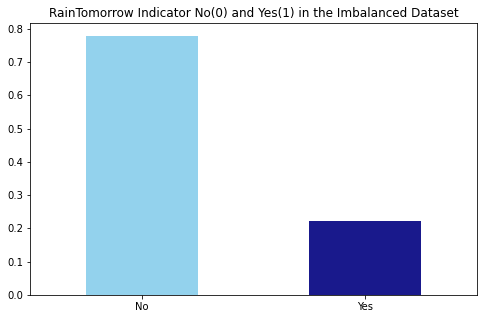

In [18]:
fig = plt.figure(figsize = (8,5))
df_model['RainTomorrow'].value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

As expected, we see the data for `RainTomorrow` is imbalanced. Majority of the data is for `No` rain vs. `Yes` for `RainTomorrow`.

We can observe that the presence of `0` and `1` is almost in the `78:22` ratio. We will be cognizant of the fact that our model may be not very effective if we don't solve for imbalance. We will discuss and adjust for this imbalance in our analysis.

## Logistic Regression Model

### Creating Logistic Regression Function

The function below creates models with various parameters supported by LogisticRegression. There are various combinations of
1. `Model Type`
2. `Class Weight`
3. `Solver`
4. `C`
5. `Penalty`
6. `Iterations`

This function runs for specific Solver, C, Penalty but takes various iterations, and we used 10 iterations.
When this function called with Solver, C, Penalty, the function runs for BOTH Class Weight, `balanced` and `None`. The result of both `balanced` and `None` is stored as single row in a dataframe.
They are stored in the same row to verify how `balanced` and `None` compares.

##### Model Type

1. `Shuffle`
2. `Stratified`

`ShuffleSplit`  — is similar to `Cross Validation` where we can specify the percentage of split for train and test data. However, in regular cross-validation, the data is not split randomly, so, it is good to shuffle the targets before applying the `cross-validation`.


`Stratified` — CV technique is very useful with unbalanced dataset. As discussed above our dataset is not balanced and rightly so, we don't expect it to rain and no-rain days to be equal in Australia. The data is expected to be unbalanced and expected to be such in future as well. So using stratified sampling techniques gives us the ability to preserve the proportion of the Rain days vs non-rain days in our dataset. We can be confident that the Train and Test split data is not leaving out important information like entire dataset is of `No` rain days which will give highly inaccurate output eventhough the accuracy might be maintained. 

In `Stratified` sampling, the data is k-1 split in favor of Train vs Test data.


References: 
https://towardsdatascience.com/understanding-8-types-of-cross-validation-80c935a4976d
https://mclguide.readthedocs.io/en/latest/sklearn/cv.html


##### Solver Options
Scikit-learn comes with five different solver options. Each solver minimize the cost function. Here are the five options:

`newton-cg` — A newton method. Newton methods use an exact Hessian matrix. It's slow for large datasets, because it computes the second derivatives.

`lbfgs` — Stands for Limited-memory Broyden–Fletcher–Goldfarb–Shanno. It approximates the second derivative matrix updates with gradient evaluations. It stores only the last few updates, so it saves memory. It isn't super fast with large data sets.

`liblinear` — Library for Large Linear Classification. Uses a coordinate descent algorithm. Coordinate descent is based on minimizing a multivariate function by solving univariate optimization problems in a loop. In other words, it moves toward the minimum in one direction at a time. It performs pretty well with high dimensionality. It does have a number of drawbacks. It can get stuck, is unable to run in parallel, and can only solve multi-class logistic regression with one-vs.-rest.

`sag` — Stochastic Average Gradient descent. A variation of gradient descent and incremental aggregated gradient approaches that uses a random sample of previous gradient values. Fast for big datasets.

`saga` — Extension of sag that also allows for L1 regularization. Should generally train faster than sag.

Reference for above definitions: https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451

##### Penalty

Used to specify the norm used in the penalization. The `newton-cg`’, `sag` and `lbfgs` solvers support only `l2` penalties. `elasticnet` is only supported by the `saga` solver. If `none` (not supported by the `liblinear` solver), no regularization is applied.

`L1`  or `Lasso` — (`LASSO` is Least Absolute Shrinkage and Selection Operator) uses a penalized least squares approach that squeezes the regression coefficients to 0 when the penalty is large. The algorithm starts with a large penalty and gradually relaxes the penalty to allow for a single variable to be added into the model (the coefficient is no longer `0`). `LASSO` uses `L1` method.

`L2` or `Ridge` — adds a penalty equal to the square of the magnitude of coefficients. `L2` will not yield sparse models and all coefficients are shrunk by the same factor (not eliminated). Ridge regression and SVMs use this method.

`elasticnet`  — Procedure identical to `LASSO` however the penalty is different. `elasticnet` uses a combination of both the `LASSO` penalty as well as the `RIDGE` regression penalty. It combine both `L1` & `L2` methods.

`none` — No penalty

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Reference for Penalty definitions: https://www.statisticshowto.com/regularization/

##### C
`C` is cost, which we run with `1.0`, `10.0` and `100.0` for each combination of Solver and Penalty.

If the solver doesn't support the penalty, those are skipped.


The dataframe stores:

1. `Model Type`
2. `Solver`
3. `C`
4. `Penalty`
5. `Iteration`
6. `AccuracyNone`
7. `MacroAvgPrecisionNone`
7. `WeightedAvgPrecisionNone`
8. `DiffMacro/WeightedNone`
9. `fprNone`
10. `tprNone`,
11. `AccuracyBalanced`
12. `MacroAvgPrecisionBalanced`
13. `WeightedAvgPrecisionBalanced`
14. `DiffMacro/WeightedBalanced`
15. `fprBalanced`
16. `tprBalanced`
17. `Classes`

`DiffMacro/WeightedBalanced` is the difference between the Presicion of `macro avg` and `Weighted`. Smaller the value, more closer they are.

`fprNone` and `tprNone` are stored to run ROC curve.

`Classes` is `Yes` and `No` as an array, which are used for labels for plots. They are constant for all rows.



In [23]:
#Logistic Regression Model

from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

#model stats dataframe columns for class weight balanced and None
model_stats_columns=["Model","Solver", "C", "Penalty","Iteration",
                         "AccuracyNone", "MacroAvgPrecisionNone","WeightedAvgPrecisionNone","DiffMacro/WeightedNone","fprNone", "tprNone",
                         "AccuracyBalanced","MacroAvgPrecisionBalanced","WeightedAvgPrecisionBalanced","DiffMacro/WeightedBalanced","fprBalanced", "tprBalanced", 
                         "Classes"
                        ]


def create_log_models(model_type,df, iterations,penalty, C, solver):
    class_weight = ['balanced', None]
    
    #Create logreg object for both class weights
    lr_clf_balanced = LogisticRegression(penalty=penalty, C=C, class_weight='balanced', solver=solver) 
    lr_clf_none = LogisticRegression(penalty=penalty, C=C, class_weight=None, solver=solver)
    
    #Store both objects in a dict for later retrival
    lr_clf_dict = { 
                    "balanced": lr_clf_balanced,
                    "None": lr_clf_none
                    }

    num_cv_iterations = iterations

   
    if "RainTomorrow" in df:
        y = df["RainTomorrow"].values # get the labels we want
        del df["RainTomorrow"] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    num_instances = len(y)
    
    cv_data = None
    if model_type == "shuffle":
        cv_data = ShuffleSplit(n_splits=num_cv_iterations,
                             test_size  = 0.2, random_state = 123)

    elif model_type == "stratified":
        cv_data = StratifiedKFold(n_splits=iterations, random_state=123, shuffle=True)
        cv_data.get_n_splits(X, y)
       
    #Initialize variables
    iter_num=0
    rows = []
    stats_dict = {}
    target_names = ['No', 'Yes']
    classes = None    
    scl_obj = StandardScaler()
    
    # Run for balanced first with same model and then None with same model
    # store the results in same row of dataframe
    # This helps to compare none and balanced macro avg
   
    for train_indices, test_indices in cv_data.split(X,y): 
        for cw in class_weight:
            X_train = X[train_indices]
            y_train = y[train_indices]
        
            scl_obj.fit(X_train)

            X_test = X[test_indices]
            y_test = y[test_indices]
            
            #Get the logistic regression object for the current cw class weight
            key = None
            if cw == None:
                key = "None"
            else:
                key = cw
                    
            lr_clf = lr_clf_dict[key]
            
            try:
                X_train_scaled = scl_obj.transform(X_train) 
                X_test_scaled = scl_obj.transform(X_test)

                lr_clf.fit(X_train_scaled,y_train)  # train object
                y_hat = lr_clf.predict(X_test_scaled) # get test set precitions
                classes = lr_clf.classes_

                acc = mt.accuracy_score(y_test,y_hat)
                conf = mt.confusion_matrix(y_test,y_hat)
                
                class_report = classification_report(y_test, y_hat, target_names, output_dict=True)
                
                # Macro avg stats
                macro_avg_precision = class_report["macro avg"]["precision"]
                macro_avg_recall = class_report["macro avg"]["recall"]
                macro_avg_f1_score = class_report["macro avg"]["f1-score"]

                #Weighted avg stats
                weighted_avg_precision = class_report["weighted avg"]["precision"]
                weighted_avg_recall = class_report["weighted avg"]["recall"]
                weighted_avg_f1_score = class_report["weighted avg"]["f1-score"]

                # Create ROC Curve
                y_test_01 = np.where(y_test =="Yes", 1, [0])
                y_hat_01 = np.where(y_hat =="Yes", 1, [0])

                fpr, tpr, threshold = metrics.roc_curve(y_test_01, y_hat_01)
                
                #Create a dict of these stats for class weight
                #dict will contain stats for balanced on one run, None for the next run
                
                                   
                stats_dict[key] = [acc, 
                          macro_avg_precision, 
                          weighted_avg_precision,
                          abs(weighted_avg_precision-macro_avg_precision),         
                          fpr, tpr ]

                print(model_type, solver,cw,C,penalty,iter_num,"✅")
            except Exception as e:
                print('Error:', str(e))
                raise
            #end try block  
        #end first for loop
        #When cursor comes here, model has ran for both None and balanced
        #Create a single row of lists combining none and balanced 
        
        row = [model_type, solver,C,penalty,iter_num] + stats_dict["None"] + stats_dict['balanced'] + [classes]
        rows.append(row)
        iter_num+=1
    #end next for loop
    
    #Create a dataframe with the model stats 
    df_ret = pd.DataFrame(rows, columns = model_stats_columns)
    return df_ret


### Running Logistic Regression with various options

The code below runs all the combinations of `Penalty`, `Solver`, `C` and shuffle types and stores in dataframe for further analysis later on.

If any combinations of `Solver` and `Penalty` isn't supported by Logistic Regression, they are skipped.

`iteration` — 10 iterations


In [22]:
from timeit import default_timer as timer

penalty=['l1','l2', 'elasticnet', 'none']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
model_type = ['shuffle', 'stratified']
C=[1.0, 10.0, 100.0]
iterations = 10

#penalty=['l2']
#solver = ['liblinear']
#model_type = ['shuffle', 'stratified']
#C=[1.0]

model_perf_df = pd.DataFrame(columns= model_stats_columns)

# Run all combinations of penalty, solver, model_type, C
# Create a giant dataframe
# Each row of dataframe contains stats for each combination of penalty, solver, model_type,C
# same row contains the stats for both None and balanced class weight
# so we can compare the balanced and None
# and pick the model whose diff in precision (for macro avg) is lowest with highest accuracy
# This model is the closest to real world

for pen in penalty:
    for c_index in C:
        for solv in solver:
            for mdl_type in model_type:
                try:
                    starttime = timer()
                    df_ret = create_log_models(model_type=mdl_type,df=df_model,iterations=iterations, penalty=pen, C=c_index, solver=solv)
                    if dt_ret is not None:
                        dt_ret["Time"] = endtime - starttime
                    
                    endtime = timer()
                    model_perf_df = model_perf_df.append(df_ret, ignore_index=True)
                    
                    #Model deletes RainTomorrow from dataframe
                    #put it back from imputed data to run for another set of model
                    df_model["RainTomorrow"] = df_impute["RainTomorrow"].values
                except Exception as e:
                    print("Error in running", str(e))
                    continue
                            

                        

Error: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.
Error: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.
shuffle liblinear balanced 1.0 l1 0 ✅
shuffle liblinear None 1.0 l1 0 ✅
shuffle liblinear balanced 1.0 l1 1 ✅
shuffle liblinear None 1.0 l1 1 ✅
shuffle liblinear balanced 1.0 l1 2 ✅
shuffle liblinear None 1.0 l1 2 ✅
shuffle liblinear balanced 1.0 l1 3 ✅
shuffle liblinear None 1.0 l1 3 ✅
shuffle liblinear balanced 1.0 l1 4 ✅
shuffle liblinear None 1.0 l1 4 ✅
shuffle liblinear balanced 1.0 l1 5 ✅
shuffle liblinear None 1.0 l1 5 ✅
shuffle liblinear balanced 1.0 l1 6 ✅
shuffle liblinear None 1.0 l1 6 ✅
shuffle liblinear balanced 1.0 l1 7 ✅
shuffle liblinear None 1.0 l1 7 ✅
shuffle liblinear balanced 1.0 l1 8 ✅
shuffle liblinear None 1.0 l1 8 ✅
shuffle liblinear ba

stratified liblinear None 100.0 l1 5 ✅
stratified liblinear balanced 100.0 l1 6 ✅
stratified liblinear None 100.0 l1 6 ✅
stratified liblinear balanced 100.0 l1 7 ✅
stratified liblinear None 100.0 l1 7 ✅
stratified liblinear balanced 100.0 l1 8 ✅
stratified liblinear None 100.0 l1 8 ✅
stratified liblinear balanced 100.0 l1 9 ✅
stratified liblinear None 100.0 l1 9 ✅
Error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
shuffle saga balanced 100.0 l1 0 ✅
shuffle saga None 100.0 l1 0 ✅
shuffle saga balanced 100.0 l1 1 ✅
shuffle saga None 100.0 l1 1 ✅
shuffle saga balanced 100.0 l1 2 ✅
shuffle saga None 100.0 l1 2 ✅
shuffle saga balanced 100.0 l1 3 ✅
shuffle saga None 100.0 l1 3 ✅
shuffle saga balanced 100.0 l1 4 ✅
shuffle saga None 100.0 l1 4 ✅
shuffle saga balanced 100.0 l1 5 ✅
shuffle saga None 100.0 l1 5 ✅
shuffle saga balanced 100.0 l1 6 ✅
shuffle saga None 100.0 l1 6 ✅
shuffle saga 

stratified saga balanced 1.0 l2 1 ✅
stratified saga None 1.0 l2 1 ✅
stratified saga balanced 1.0 l2 2 ✅
stratified saga None 1.0 l2 2 ✅
stratified saga balanced 1.0 l2 3 ✅
stratified saga None 1.0 l2 3 ✅
stratified saga balanced 1.0 l2 4 ✅
stratified saga None 1.0 l2 4 ✅
stratified saga balanced 1.0 l2 5 ✅
stratified saga None 1.0 l2 5 ✅
stratified saga balanced 1.0 l2 6 ✅
stratified saga None 1.0 l2 6 ✅
stratified saga balanced 1.0 l2 7 ✅
stratified saga None 1.0 l2 7 ✅
stratified saga balanced 1.0 l2 8 ✅
stratified saga None 1.0 l2 8 ✅
stratified saga balanced 1.0 l2 9 ✅
stratified saga None 1.0 l2 9 ✅
shuffle newton-cg balanced 10.0 l2 0 ✅
shuffle newton-cg None 10.0 l2 0 ✅
shuffle newton-cg balanced 10.0 l2 1 ✅
shuffle newton-cg None 10.0 l2 1 ✅
shuffle newton-cg balanced 10.0 l2 2 ✅
shuffle newton-cg None 10.0 l2 2 ✅
shuffle newton-cg balanced 10.0 l2 3 ✅
shuffle newton-cg None 10.0 l2 3 ✅
shuffle newton-cg balanced 10.0 l2 4 ✅
shuffle newton-cg None 10.0 l2 4 ✅
shuffle newton-cg 

shuffle newton-cg None 100.0 l2 6 ✅
shuffle newton-cg balanced 100.0 l2 7 ✅
shuffle newton-cg None 100.0 l2 7 ✅
shuffle newton-cg balanced 100.0 l2 8 ✅
shuffle newton-cg None 100.0 l2 8 ✅
shuffle newton-cg balanced 100.0 l2 9 ✅
shuffle newton-cg None 100.0 l2 9 ✅
stratified newton-cg balanced 100.0 l2 0 ✅
stratified newton-cg None 100.0 l2 0 ✅
stratified newton-cg balanced 100.0 l2 1 ✅
stratified newton-cg None 100.0 l2 1 ✅
stratified newton-cg balanced 100.0 l2 2 ✅
stratified newton-cg None 100.0 l2 2 ✅
stratified newton-cg balanced 100.0 l2 3 ✅
stratified newton-cg None 100.0 l2 3 ✅
stratified newton-cg balanced 100.0 l2 4 ✅
stratified newton-cg None 100.0 l2 4 ✅
stratified newton-cg balanced 100.0 l2 5 ✅
stratified newton-cg None 100.0 l2 5 ✅
stratified newton-cg balanced 100.0 l2 6 ✅
stratified newton-cg None 100.0 l2 6 ✅
stratified newton-cg balanced 100.0 l2 7 ✅
stratified newton-cg None 100.0 l2 7 ✅
stratified newton-cg balanced 100.0 l2 8 ✅
stratified newton-cg None 100.0 l2 8 

Error: l1_ratio must be between 0 and 1; got (l1_ratio=None)
Error in running l1_ratio must be between 0 and 1; got (l1_ratio=None)
Error: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
Error in running Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
Error: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.
Error in running Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.
Error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Error in running Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Error in running Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Error: l1_ratio must be between 0 and 1; got (l1_ratio=None)
Error in running l1_ratio must be between 0 and 1; got (l1_ratio=None)
shuffle newton-cg balanced 1.0 non

stratified newton-cg None 10.0 none 7 ✅
stratified newton-cg balanced 10.0 none 8 ✅
stratified newton-cg None 10.0 none 8 ✅
stratified newton-cg balanced 10.0 none 9 ✅
stratified newton-cg None 10.0 none 9 ✅
shuffle lbfgs balanced 10.0 none 0 ✅
shuffle lbfgs None 10.0 none 0 ✅
shuffle lbfgs balanced 10.0 none 1 ✅
shuffle lbfgs None 10.0 none 1 ✅
shuffle lbfgs balanced 10.0 none 2 ✅
shuffle lbfgs None 10.0 none 2 ✅
shuffle lbfgs balanced 10.0 none 3 ✅
shuffle lbfgs None 10.0 none 3 ✅
shuffle lbfgs balanced 10.0 none 4 ✅
shuffle lbfgs None 10.0 none 4 ✅
shuffle lbfgs balanced 10.0 none 5 ✅
shuffle lbfgs None 10.0 none 5 ✅
shuffle lbfgs balanced 10.0 none 6 ✅
shuffle lbfgs None 10.0 none 6 ✅
shuffle lbfgs balanced 10.0 none 7 ✅
shuffle lbfgs None 10.0 none 7 ✅
shuffle lbfgs balanced 10.0 none 8 ✅
shuffle lbfgs None 10.0 none 8 ✅
shuffle lbfgs balanced 10.0 none 9 ✅
shuffle lbfgs None 10.0 none 9 ✅
stratified lbfgs balanced 10.0 none 0 ✅
stratified lbfgs None 10.0 none 0 ✅
stratified lbfgs

shuffle sag None 100.0 none 4 ✅
shuffle sag balanced 100.0 none 5 ✅
shuffle sag None 100.0 none 5 ✅
shuffle sag balanced 100.0 none 6 ✅
shuffle sag None 100.0 none 6 ✅
shuffle sag balanced 100.0 none 7 ✅
shuffle sag None 100.0 none 7 ✅
shuffle sag balanced 100.0 none 8 ✅
shuffle sag None 100.0 none 8 ✅
shuffle sag balanced 100.0 none 9 ✅
shuffle sag None 100.0 none 9 ✅
stratified sag balanced 100.0 none 0 ✅
stratified sag None 100.0 none 0 ✅
stratified sag balanced 100.0 none 1 ✅
stratified sag None 100.0 none 1 ✅
stratified sag balanced 100.0 none 2 ✅
stratified sag None 100.0 none 2 ✅
stratified sag balanced 100.0 none 3 ✅
stratified sag None 100.0 none 3 ✅
stratified sag balanced 100.0 none 4 ✅
stratified sag None 100.0 none 4 ✅
stratified sag balanced 100.0 none 5 ✅
stratified sag None 100.0 none 5 ✅
stratified sag balanced 100.0 none 6 ✅
stratified sag None 100.0 none 6 ✅
stratified sag balanced 100.0 none 7 ✅
stratified sag None 100.0 none 7 ✅
stratified sag balanced 100.0 none 8

In [68]:
#perf_model_copy = model_perf_df.copy()
model_perf_df = perf_model_copy.copy()


In these models we used two different methodologies for cross validation namely `Shuffle` and `Stratified`.

`ShuffleSplit`  — is similar to `Cross Validation` where we can specify the percentage of split for train and test data. However, in regular cross-validation, the data is not split randomly, so, it is good to shuffle the targets before applying the `cross-validation`.


`Stratified` — CV technique is very useful with unbalanced dataset. As discussed above our dataset is not balanced and rightly so, we don't expect it to rain and no-rain days to be equal in Australia. The data is expected to be unbalanced and expected to be such in future as well. So using stratified sampling techniques gives us the ability to preserve the proportion of the Rain days vs non-rain days in our dataset. We can be confident that the Train and Test split data is not leaving out important information like entire dataset is of `No` rain days which will give highly inaccurate output eventhough the accuracy might be maintained. 

In `Stratified` sampling, the data is k-1 split in favor of Train vs Test data.


References: 
https://towardsdatascience.com/understanding-8-types-of-cross-validation-80c935a4976d
https://mclguide.readthedocs.io/en/latest/sklearn/cv.html


After running the big `Logistic Regression` model for several combinations. We got output for 660 models.

To compare the outputs and make it easier to identify the most appropriate model in terms of accuracy, precision and other factors applicable for Machine Learning models. We decided to put a list of subset of variables including:

`Model` — specifies which technique was used for the logistic model. In this case its between ShuffleSplit and Stratified.

`AccuracyNone` —  specifies the Accuracy observed by the model where data was not `balanced`.

`DiffMacro/WeightedNone` — takes the `Macro Average` and `Weighted Average` of `Precision` from the classification matrix and calculates the difference. The reason to calculate the difference is to check how much variation is in the Precision values based on how the data is split. More details about Precision and Averages is provided below. This variation is calculated on the non `balanced` data.

`AccuracyBalanced` — specifies the Accuracy observed by the model where data was `balanced`.

`DiffMacro/WeightedBalanced` — same as above this variable calculates the difference between Macro and Weighted Average of Precision of a `balanced` data.

### Important Terms

`Accuracy` — is a ratio of correctly predicted observation to the total observations. It is a very important aspect to define the success of a model but just the measurement on its own can be deceiving if the observations are not equal for each class. In such cases we might be predicting accurately for one particular class with large observation and may not do very well for other classes.

`Precision` — is the ratio of correctly predicted positive observations to the total predicted positive observations. Precision = TP/TP+FP  

`Weighted Average` — can be calculated on various output variables of the classification report like Precision, Recall, f1-score. As the name suggests it gives the weighted average of the parameter based on the number of observations or values for each class.

`Macro Average` — similar to weighted average, macro average can also be calculated on various output variables of the classification report like Precision, Recall, f1-score. However, the similarity ends here as unlike weighted average, we don't use weights based on the number of observations, rather equal weights are given to each class to calcualte the value. This tells us if the Precision is as good if the dataset was balanced.

References:
https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
https://datascience.stackexchange.com/questions/65839/macro-average-and-weighted-average-meaning-in-classification-report

In [69]:
from  matplotlib import pyplot
import seaborn

def draw_scatter(df, x,y):

    seaborn.set(style='ticks')
    cv_type = ['shuffle', 'stratified']

    #fg = seaborn.FacetGrid(data=model_perf_df, hue='Model', hue_order=cv_type, height=8, aspect=1.61, ylim=(0,1))
    fg = seaborn.FacetGrid(data=model_perf_df, hue='Model', hue_order=cv_type, height=8, aspect=1.61)
    fg.map(pyplot.scatter, x, y ).add_legend()

    for i, ax in enumerate(fg.fig.axes):   
         ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


#Reference: https://stackoverflow.com/questions/14885895/color-by-column-values-in-matplotlib
#Ref for Axis rotation: https://stackoverflow.com/questions/26540035/rotate-label-text-in-seaborn-factorplot/43256409#43256409

### Compare Shuffle vs Stratified

To compare `Shuffle` and `Stratified`, we plot Shuffle and Stratified with `AccuracyNone` (accuracy for non-balanced data) and `AccuracyBalanced` (accuracy for balanced data).

In the plots below, we see the difference between `Shuffle` and `Stratified` in absolute values is very small

1. `AccuracyNone` values range from `0.871` to `0.877`, which is `0.006`, is a very small difference
2. `AccuraceBalanced` values range from `0.847` to `0.853`, which is `0.006`, is also very small difference

Based on the Accuracy alone, we cannot pick any models from one over other. 
We have to do further analysis of better model, as all models are very close to each other for our dataset.


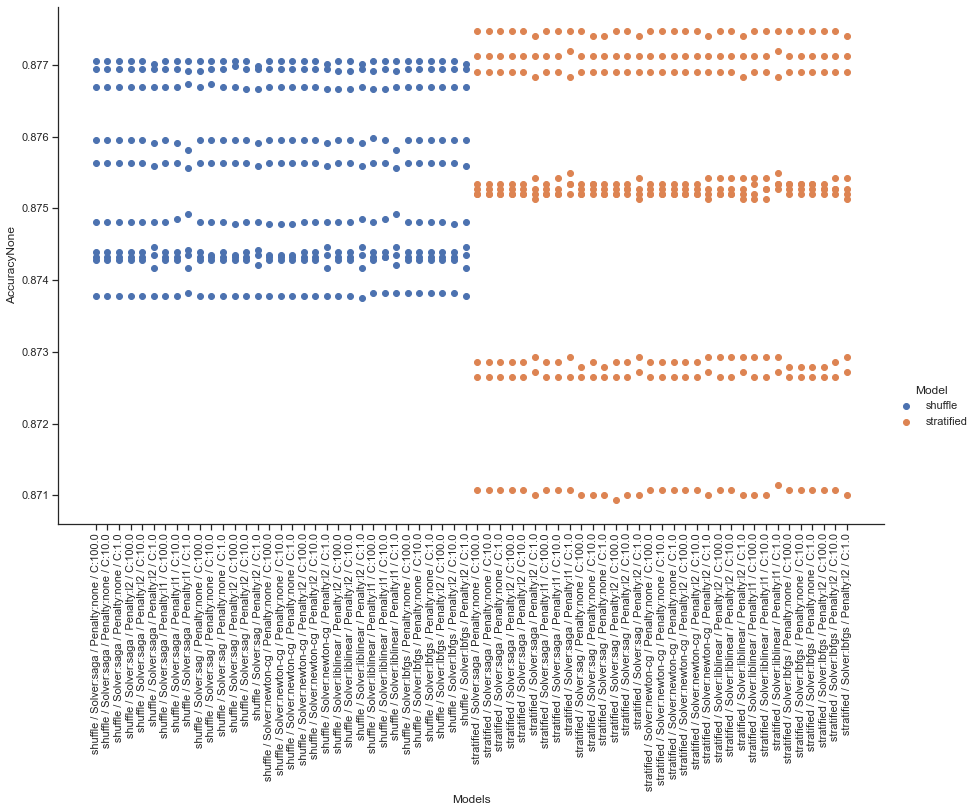

In [71]:

#Create a plot by looking shuffle vs stratefied

model_perf_df['Models'] = model_perf_df['Model'] + " / Solver:" + model_perf_df['Solver'] + " / Penalty:" + model_perf_df['Penalty'] + " / C:"+model_perf_df['C'].astype(str)

model_perf_df = model_perf_df.sort_values(by=['Models'],ascending=False)

#Sort by accuracy and take top 5

#model_perf_df = model_perf_df.nlargest(5, 'AccuracyNone')

draw_scatter(df=model_perf_df, x='Models', y='AccuracyNone')


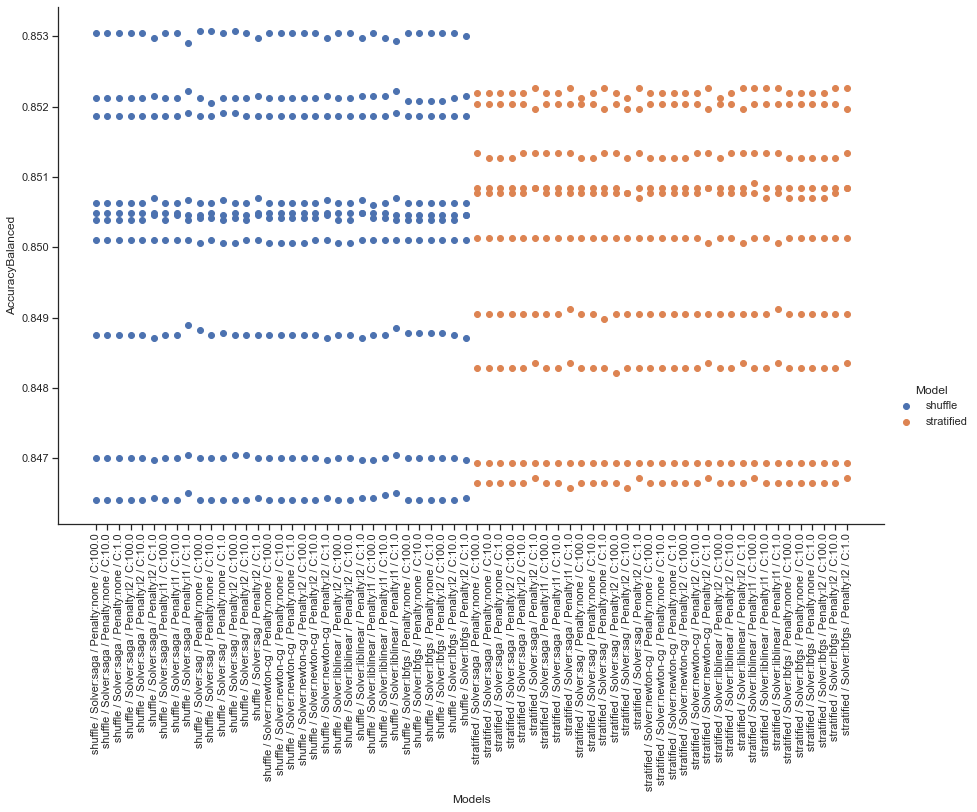

In [72]:

#Create a plot by looking shuffle vs stratefied

model_perf_df['Models'] = model_perf_df['Model'] + " / Solver:" + model_perf_df['Solver'] + " / Penalty:" + model_perf_df['Penalty'] + " / C:"+model_perf_df['C'].astype(str)

model_perf_df = model_perf_df.sort_values(by=['Models'],ascending=False)

#Sort by accuracy and take top 5

#model_perf_df = model_perf_df.nlargest(5, 'AccuracyNone')

draw_scatter(df=model_perf_df, x='Models', y='AccuracyBalanced')



### Macro Avg vs Weight Avg Precision comparisons

As we couldn't pick the models just from `Accuracy`, we are further our analysis by plotting the difference between the `Macro Avg` precision and `Weighted Avg` precision for all the models. 


   `DiffMacro/WeightedNone` — takes the `Macro Average` and `Weighted Average` of `Precision` from the classification matrix and calculates the difference. The reason to calculate the difference is to check how much variation is in the `Precision` values based on how the data is split. 

   `DiffMacro/WeightedBalanced` — same as above this variable calculates the difference between Macro and Weighted Average of Precision of a `balanced` data.
   
The smaller the difference between `Weight Avg` and `Macro Avg`, the model is closer to real world and also consistent.   



In [75]:
### Weighted Avg vs Macro Avg Precision Plots


cv_type = ['shuffle', 'stratified']
fg = seaborn.FacetGrid(data=model_perf_df, hue='Model', hue_order=cv_type, height=8, aspect=1.61)    
fg.map(pyplot.scatter, 'Models', 'DiffMacro/WeightedBalanced').add_legend()

for i, ax in enumerate(fg.fig.axes):   ## getting all axes of the fig object
     ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

#Reference: https://stackoverflow.com/questions/14885895/color-by-column-values-in-matplotlib

#Ref for Axis rotation: https://stackoverflow.com/questions/26540035/rotate-label-text-in-seaborn-factorplot/43256409#43256409

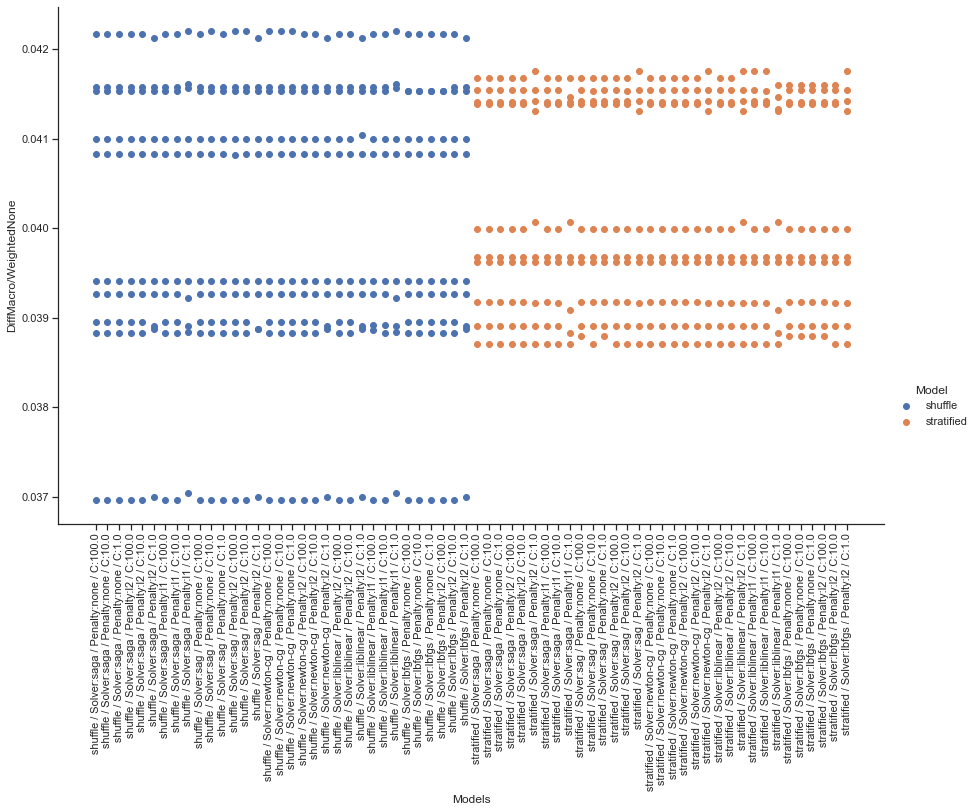

In [74]:
cv_type = ['shuffle', 'stratified']
fg = seaborn.FacetGrid(data=model_perf_df, hue='Model', hue_order=cv_type, height=8, aspect=1.61)    
fg.map(pyplot.scatter, 'Models', 'DiffMacro/WeightedNone').add_legend()

for i, ax in enumerate(fg.fig.axes):   ## getting all axes of the fig object
     ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)



In [ ]:
order = model_perf_df['Models'].unique()
model_perf_df['Models'] = pd.Categorical(model_perf_df['Models'], order)
model_perf_df.sort_values(by=['Models'], inplace=True)

In [65]:
#Lets focus on Stratified

#Remove all shuffle

model_perf_df.drop(model_perf_df[model_perf_df.Model == "shuffle"].index, inplace=True)

In [ ]:
#ROC Curve of top

top_model = model_perf_df.head(1)

for index, row in top_model.iterrows():
    fpr = row["fprNone"]
    tpr = row["tprNone"]
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
top_model

In [ ]:
roc_auc =metrics.auc([0.,0.0591311, 1.],[0.,0.64278846,1.])
fpr = [0.,0.0591311, 1.]
tpr = [0.,0.64278846,1.]
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## SVM Model

The function below creates a `SVM` model with the given parameters.

The function accepts following paramters:

1. iterations
2. kernel
3. degree
4. gamma


We are using StratifiedKFold because ShuffleSplit (with 80/20 split) is not as good as Stratified for our data. We have explained the rationale for using Stratified in the Logistic Regression section [above](# Look-only-Stratified-models).

We are using `Class Weight` as `None`, as `StratifiedKFold` works well for our data; so we decided not to use `Class Weight` as balanced.

We are only running the certain combinations we found useful for our data from Logistic Regression, as we are constrianed by time, as running all combinations of parameters for SVM takes a long time to complete.

`gamma` — is run only with `auto`, as our data is scaled already. We decided not to use `scale` option.

`iteration` — 10 iterations


In [ ]:
def create_svm_model(df, C, iterations):
    num_cv_iterations = iterations
  
    if "RainTomorrow" in df:
        y = df["RainTomorrow"].values # get the labels we want
        del df["RainTomorrow"] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    num_instances = len(y)
    
    # ShuffleSplit is not a good representation of our data. We already established in the previous
    # models that Stratified is better for our model.
    # We are choosing to run only Stratified for SVM
    
    cv_data = StratifiedKFold(n_splits=iterations, random_state=123, shuffle=True)
    cv_data.get_n_splits(X, y)

    iter_num=0
    rows = []
    scl_obj = StandardScaler()
    
    key = None
        if cw == None:
            key = "None"
        else:
            key = 'balanced'
    
    for train_indices, test_indices in cv_data.split(X,y): 
        X_train = X[train_indices]
        y_train = y[train_indices]
        
        scl_obj.fit(X_train)

        X_test = X[test_indices]
        y_test = y[test_indices]
        try:
            X_train_scaled = scl_obj.transform(X_train) 
            X_test_scaled = scl_obj.transform(X_test)
            y_hat = None
          
            
            svm_clf = SVC(C=C, kernel="rbf", degree=3, gamma='auto') 
            svm_clf.fit(X_train_scaled, y_train)  # train object
            y_hat = svm_clf.predict(X_test_scaled) # get test set precitions
            classes = svm_clf.classes_

            acc = mt.accuracy_score(y_test,y_hat)
            conf = mt.confusion_matrix(y_test,y_hat)
            target_names = ['No', 'Yes']
            class_report = classification_report(y_test, y_hat, target_names, output_dict=True)
            
            # Macro avg stats
            macro_avg_precision = class_report["macro avg"]["precision"]
            macro_avg_recall = class_report["macro avg"]["recall"]
            macro_avg_f1_score = class_report["macro avg"]["f1-score"]
            
            #Weighted avg stats
            weighted_avg_precision = class_report["weighted avg"]["precision"]
            weighted_avg_recall = class_report["weighted avg"]["recall"]
            weighted_avg_f1_score = class_report["weighted avg"]["f1-score"]
            
            
            # Create ROC Curve
            y_test_01 = np.where(y_test =="Yes", 1, [0])
            y_hat_01 = np.where(y_hat =="Yes", 1, [0])

            fpr, tpr, threshold = metrics.roc_curve(y_test_01, y_hat_01)
            model_stats[cw] = [acc, conf, target_names, ]
            
            print(model_type, solver,cw,C,penalty,iter_num,"✅")
        except Exception as e:
            print('Error:', str(e))
            raise
        iter_num+=1   
   
    df_ret = pd.DataFrame(rows, columns=["ModelType","Solver", "ClassWeight", "C", "Penalty","Iteration","Accuracy","ConfusionMatrix", 
                                         "ClassificationReport","fpr", "tpr", "classes"])
    return df_ret

In [ ]:
model_perf_df.sort_values(by=['Accuracy'],ascending=False).head(5)


In [ ]:
C=[1.0, 10.0, 100.0]
iterations = 10

for c_i in C:
    df_ret_svm = create_svm_model(df=df_model, C=c_i ,iterations=iterations)
    model_perf_df = model_perf_df.append(dt_ret_svm)


In [ ]:
# ROC
for index, row in df_ret_svm.iterrows():
    fpr = row["fpr"]
    tpr = row["tpr"]
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
# now let's make a pandas Series with the names and values, and plot them

weights = pd.Series(lr_clf.coef_[0],index=df_model.columns)
weights.plot(kind='bar', figsize=(14,6))



In [ ]:
disp = mt.ConfusionMatrixDisplay(confusion_matrix=conf[1])
disp.plot()

In [ ]:
print(df_ret)

In [ ]:
df_model

## Alternative/Shorter version of logistic regression

In [ ]:
# this does the exact same thing as the above block of code, but with shorter syntax

for iter_num,(train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit([train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict([test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

In [ ]:
#Logistic Regression Function
#Run with various parameters
from sklearn.model_selection import cross_val_score

def logistic_regression_short(df, iterations,class_weight, penalty, solver, C, l1_ratio):
    lr_clf = LogisticRegression(penalty=penalty, C=C, class_weight=class_weight, solver=solver) 

  
    if "RainTomorrow" in df:
        y = df["RainTomorrow"].values # get the labels we want
        del df["RainTomorrow"] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    rows = []
    iter_num = 0
    
    try:
        # train the reusable logisitc regression model on the training data
        accuracies = cross_val_score(lr_clf, X, y=y, cv=iterations) 
        for index, acc in enumerate(accuracies):
            rows.append([solver,class_weight,C,penalty,index, acc, None])
    except Exception as e:
        print("Error in running", solver,class_weight,C,penalty,iter_num, str(e))
        
        
    df_ret = pd.DataFrame(rows, columns=["Solver", "ClassWeight", "C", "Penalty","Iteration","Accuracy","ConfusionMatrix"])
    return df_ret

In [ ]:
# and here is an even shorter way of getting the accuracies for each training and test set

accuracies = logistic_regression_short() # this also can help with parallelism
print(accuracies)

In [ ]:
# Looking at feature importance 

import shap # SHAP for Explaining Models
shap.initjs()
# Create a tree explainer and understanding the values we have 
shap_ex = shap.LinearExplainer(lr_clf, X_test)
vals = shap_ex.shap_values(X_test)
shap.summary_plot(vals, df_model.columns, plot_type="bar")

# Reference: https://shap.readthedocs.io/en/latest/

In [ ]:
# Summarize the effect of all the features through SHAP summary plot:
explainer = shap.Explainer(lr_clf, X_train, feature_names=df_model.columns)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

# Reference: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.html

Explaining the logistic model for Rain Tomorrow prediction:

SHAP summary plots give us a birds-eye view of feature importance and what is driving it. The values of the features are their TF-IDF values.

The above SHAP summary plot is made of many dots. Each dot has three characteristics:

Vertical location shows what feature it is depicting
Color shows whether that feature was high or low for that row of the dataset.
Horizontal location shows whether the effect of that value caused a higher or lower prediction.
For example, the point in the upper left was for 'Sunshine' that caused lower chances of Rain Tomorrow, reducing the prediction by 2.

Some things the summary plot is  able to easily pick out:-

Remember that higher means more likely to be negative, so in the plots above the “red” features are actually helping raise the chance for Rain Tomorrow, while the negative features are lowering the chance for Rain Tomorrow.
The model ignored around 56 features which were of lower importance in predicting the chances of Rain Tomorrow.
Usually 'WindGustSpeed' has moderate effert on the prediction, but there are extreme cases of 'WindGustSpeed' where a high value still caused moderate level of prediction.
High values of Goal scored caused higher predictions, and low values caused low predictions

Reference: https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values

In [ ]:
# Explaining why a sample weather record # 200 is classified as Rain Tomorrow (Yes/No)?
ind = 200
shap.plots.force(shap_values[ind])
# Reference: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.html

In [ ]:
# Heatmap plot provides another global view of the model’s behavior, with a focus on predictions for Rain Tomorrow.
#shap.plots.heatmap(shap_values)

In [ ]:
groups_by_time = {
    '3pm': [f for f in df_impute if '3pm' in f],
    '9am': [f for f in df_impute if '9am' in f],
    'not_time_based': [f for f in df_impute if '9am' not in f and '3pm' not in f]
}

groups_by_type = {
    'humidity_and_rain': ['Rainfall',
                          'Evaporation',
                          'Humidity9am',
                          'Humidity3pm',
                          'RainToday'],
    'temperature': ['MinTemp',
                    'MaxTemp',
                    'Temp9am',
                    'Temp3pm'],
    'sun_and_clouds': ['Cloud9am',
                       'Cloud3pm',
                       'Sunshine'],
    'wind_and_pressure': ['WindGustDir',
                          'WindGustSpeed',
                          'WindDir9am',
                          'WindDir3pm',
                          'WindSpeed9am',
                          'WindSpeed3pm',
                          'Pressure9am',
                          'Pressure3pm'],
    'location': ['Location']
}

shap_time = grouped_shap(shap_vals, df_impute, groups_by_time)
shap_type = grouped_shap(shap_vals, df_impute, groups_by_type)



### Oversampled


In [ ]:

no = df_impute[df_impute.RainTomorrow == 0]
yes = df_impute[df_impute.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

In [ ]:
#get_dummies using oversampled dataframe

# perform one-hot encoding of the categorical data "embarked"
gust_df = pd.get_dummies(oversampled.WindGustDir,prefix='GustDir')
wind3pm_df = pd.get_dummies(oversampled.WindDir3pm,prefix='Wind3pm')
wind9am_df = pd.get_dummies(oversampled.WindDir9am,prefix='Wind9am')
oversampled = pd.concat((oversampled,gust_df, wind3pm_df, wind9am_df),axis=1) # add back into the dataframe

# replace the current Sex atribute with something slightly more intuitive and readable
oversampled['IsRainToday'] = oversampled.RainToday=='Yes' 
oversampled.IsRainToday = oversampled.IsRainToday.astype(np.int)

oversampled.info()

In [ ]:
fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

In [ ]:
len(oversampled)

In [ ]:
# Dropping categorical columns

oversampled = oversampled.drop(['WindDir3pm', 'WindDir9am', 'WindGustDir', 'RainToday'], axis = 1)

In [ ]:
#Shufflesplit using oversampled dataframe

from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if "RainTomorrow" in oversampled:
    y = oversampled["RainTomorrow"].values # get the labels we want
    del oversampled["RainTomorrow"] # get rid of the class label
    X_over = oversampled.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object_over = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state = 123)
                         
print(cv_object_over)